In [10]:
# -*- coding: utf-8 -*-
#  Copyright 2024 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Efficient sampling with Laplace priors

In this notebook, we explore methods for efficient sampling in solving inverse problems with Laplace priors.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cuqi
from cuqi.distribution import Laplace, Gaussian, JointDistribution

## Smoothed Laplace prior

The Laplace distribution is a commonly used prior to enforce sparsity, and we also hope to use it in this notebook. The probability density function of a Laplace distribution is of form
$$p(x|\mu, b)\propto\exp(-\frac{|x-\mu|}{b}),$$
where $\mu$ is the mean and $b$ is the scale. Unfortunately, the density function is not differentiable arround $\mu$, and this poses difficulties to gradient-based samplers. To overcome this issue, we "smooth" the Laplace distribution by introducing a smoothing parameter $\epsilon>0$ and the density function becomes
$$p(x|\mu, b)\propto\exp(-\frac{\sqrt{(x-\mu)^2 + \epsilon}}{b}).$$
The Python implementation of such a smoothed Laplace is as follows:

In [12]:
class LaplaceSmoothed(cuqi.distribution.Laplace):
    def __init__(self, beta, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta
  
    def logpdf(self, x):
        if isinstance(x, (float,int)):
            x = np.array([x])
        return self.dim*(np.log(0.5/self.scale)) - np.sum(np.sqrt((x-self.location)**2+self.beta))/self.scale

    def gradient(self, val):
        if isinstance(val, (float,int)):
            val = np.array([val])
        return -np.array((val - self.location)/self.scale/np.sqrt((val-self.location)**2+self.beta))

## Verification of implementation

### 1. `logpdf` and `gradient`
Comparison of `logpdf` and `gradient` of the smoothed Laplace distribution against the Laplace distribution is shown below:

/var/folders/6l/nx63qk9s1l7gst1rbgdfb5vc0000gp/T/ipykernel_91147/2992480695.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  laplace_pdf_values[i] = laplace.logpdf(x[i])
/var/folders/6l/nx63qk9s1l7gst1rbgdfb5vc0000gp/T/ipykernel_91147/2992480695.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothed_laplace_grad_values[i] = smoothed_laplace.gradient(x[i])
/var/folders/6l/nx63qk9s1l7gst1rbgdfb5vc0000gp/T/ipykernel_91147/2992480695.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation

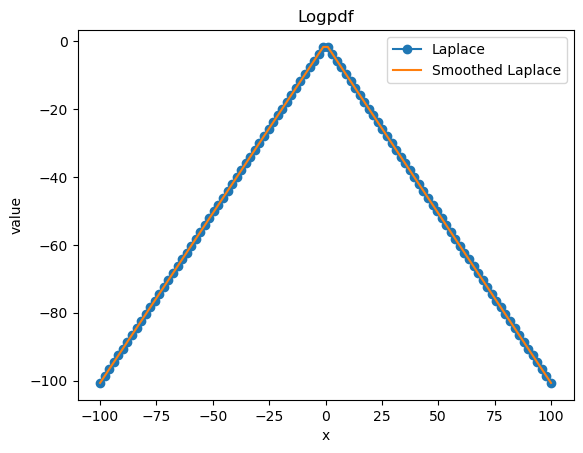

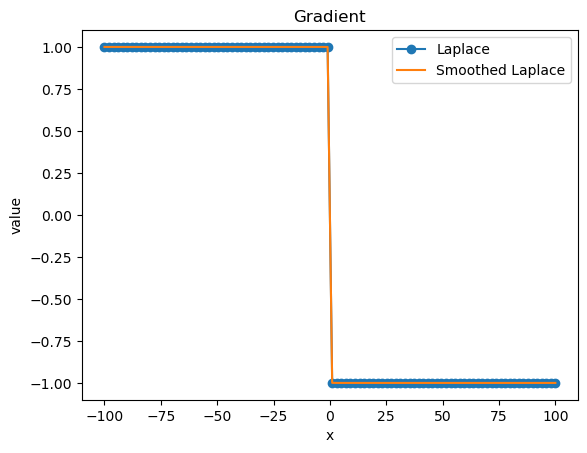

In [13]:
laplace = cuqi.distribution.Laplace(np.array([0]), np.array([1]))
smoothed_laplace = LaplaceSmoothed(location = np.array([0]), scale=1, beta=1e-3)
x = np.linspace(-100, 100, 100)
smoothed_laplace_pdf_values = np.zeros(x.shape)
laplace_pdf_values = np.zeros(x.shape)
smoothed_laplace_grad_values = np.zeros(x.shape)
laplace_grad_values = np.zeros(x.shape)
dx = 1e-4
for i in range(len(x)):
    smoothed_laplace_pdf_values[i] = smoothed_laplace.logpdf(x[i])
    laplace_pdf_values[i] = laplace.logpdf(x[i])
    smoothed_laplace_grad_values[i] = smoothed_laplace.gradient(x[i])
    laplace_grad_values[i] = (laplace.logpdf(x[i])-laplace.logpdf(x[i]-dx))/dx
plt.figure()
plt.plot(x, laplace_pdf_values, '-o', label='Laplace')
plt.plot(x, smoothed_laplace_pdf_values, label='Smoothed Laplace')
plt.xlabel('x')
plt.ylabel('value')
plt.legend()
plt.title('Logpdf')
plt.figure()
plt.plot(x, laplace_grad_values, '-o', label='Laplace')
plt.plot(x, smoothed_laplace_grad_values, label='Smoothed Laplace')
plt.xlabel('x')
plt.ylabel('value')
plt.title('Gradient')
plt.legend()

### 2. Drawing samples with NUTS

With such a smoothed Laplace distribution, we can efficiently draw samples from this distribution with a gradient-based sampler. Here we choose NUTS, and the histogram of the samples is also plotted:

Sample 22000 / 22000


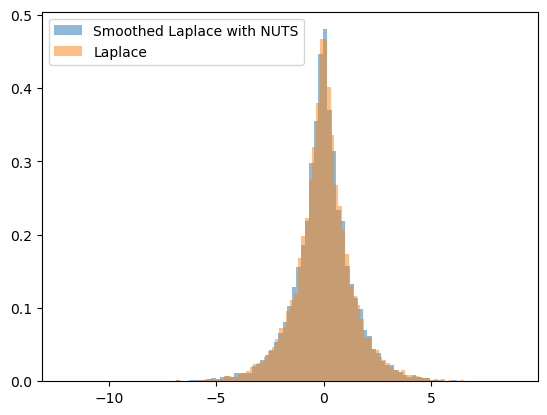

In [14]:
simple_nuts = cuqi.sampler.NUTS(smoothed_laplace)
simple_nuts_samples = simple_nuts.sample(20000, 2000)
plt.figure()
plt.hist(simple_nuts_samples.samples.flatten(), bins=100, density=True, alpha=0.5, label='Smoothed Laplace with NUTS');
# plt.title("Samples from smoothed Laplace with NUTS")
exact_laplace_samples = laplace.sample(20000)
# plt.figure()
plt.hist(exact_laplace_samples.samples.flatten(), bins=100, density=True, alpha=0.5, label='Laplace');
plt.legend()

### 3. Application in posterior sampling

$$y = x + \epsilon$$
where $x$ follows a (smoothed) Laplace distribution and $\epsilon$ follows a Gaussian.

#### A simple 2-dimensional problem

We start with a parameters with only two parameters. 

Sample 6000 / 6000


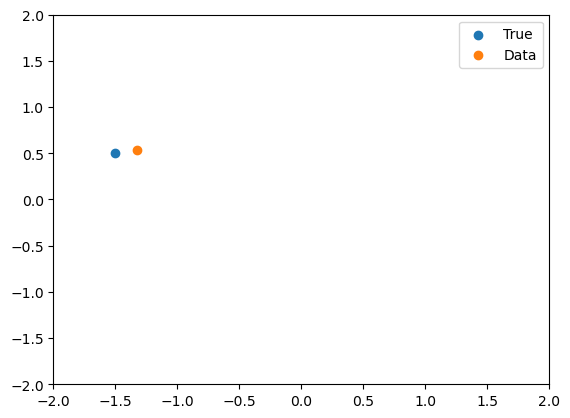

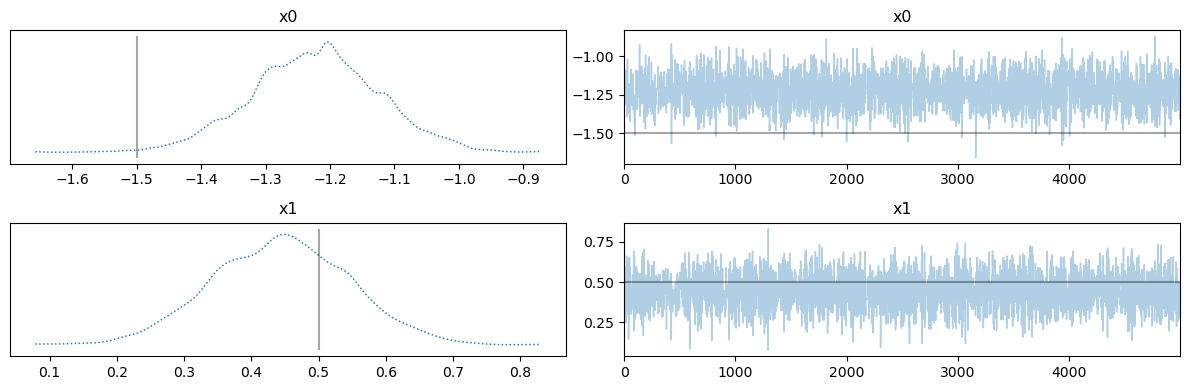

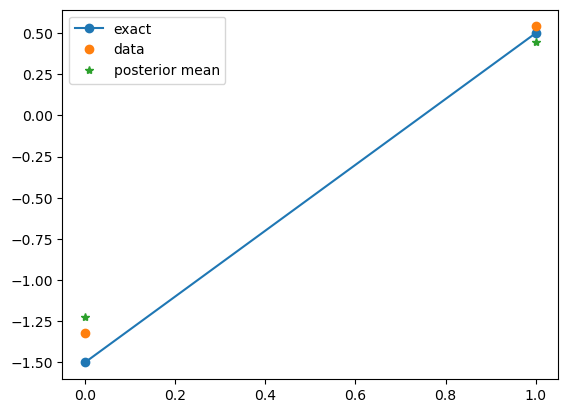

In [20]:
np.random.seed(0)

x = LaplaceSmoothed(location = np.array([0, 0]), scale=1e-1, beta=1e-5)
# x = cuqi.distribution.Gaussian(np.array([0, 0]), 1)

# x_exact = x.sample().to_numpy()
x_exact = np.array([-1.5, 0.5])

noise_std = 0.1
y_data = x_exact + np.random.randn(2)*noise_std

plt.figure()
plt.scatter(x_exact[0], x_exact[1], label='True')
plt.scatter(y_data[0], y_data[1], label='Data')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend()

A_simple_matrix = np.eye(2)
A_simple = cuqi.model.LinearModel(A_simple_matrix)
y = Gaussian(A_simple@x, cov= noise_std**2)

x_y = JointDistribution(x, y)
p = x_y(y=y_data)
simple_nuts = cuqi.sampler.NUTS(p)
# simple_nuts = cuqi.sampler.MALA(p, scale=0.01)
simple_nuts_samples = simple_nuts.sample(5000, 1000)
simple_nuts_samples.plot_trace(exact=x_exact)

plt.figure()
plt.plot(x_exact, '-o', label='exact')
plt.plot(y_data, 'o', label='data')
plt.plot(simple_nuts_samples.mean(), '*', label='posterior mean')
plt.legend()

Then we move to a problem with 50 parameters.

Sample 5100 / 5100
Selecting 5 randomly chosen variables


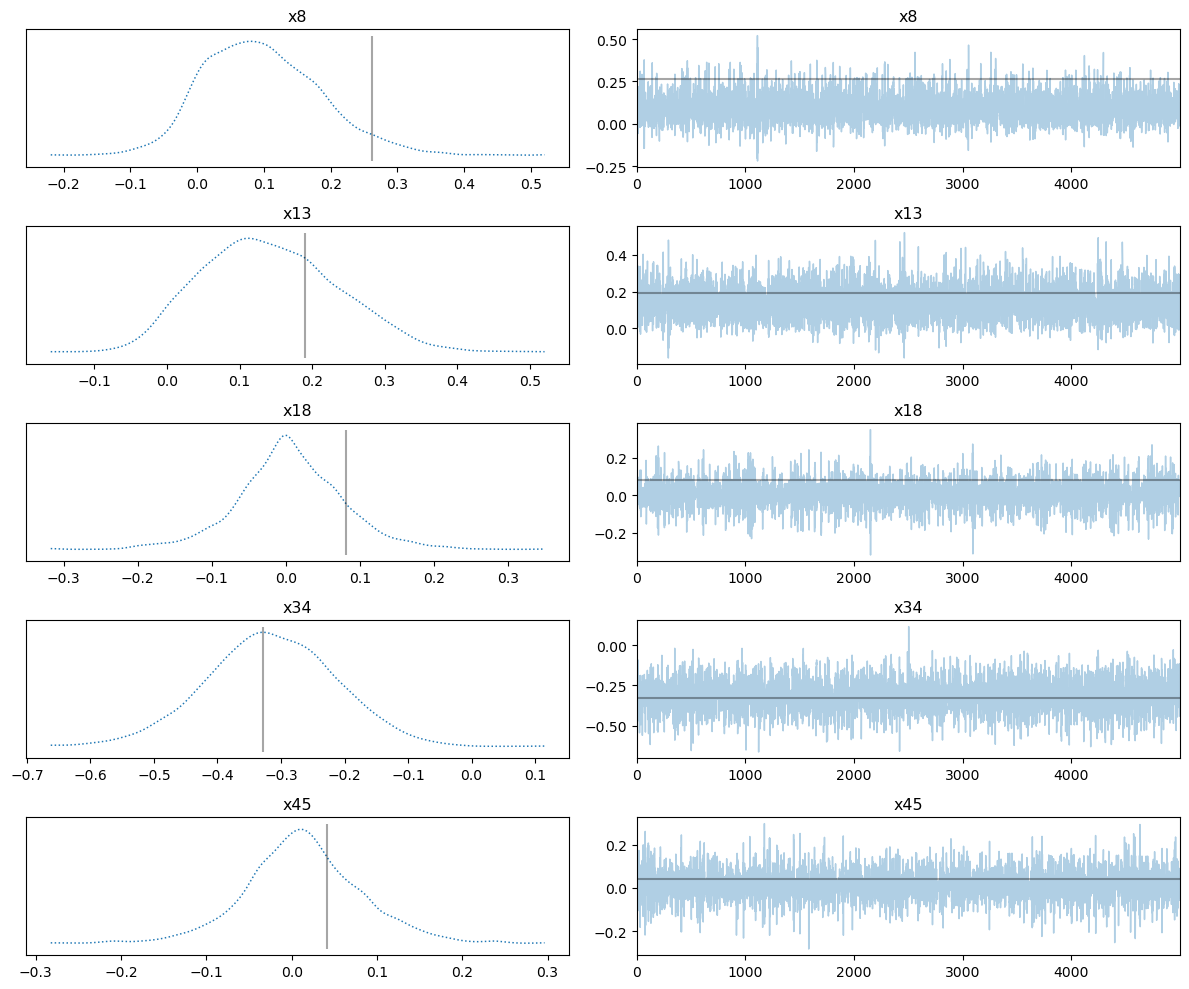

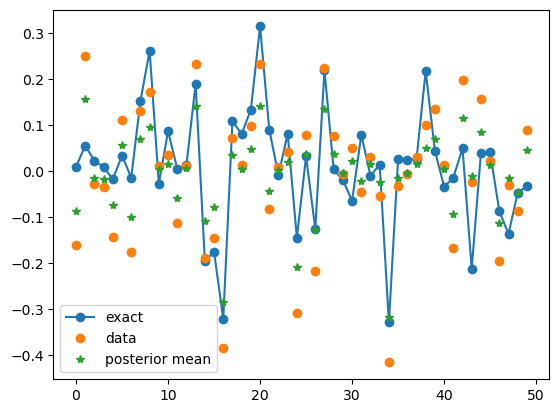

In [21]:
# # a higher dimension problem
# np.random.seed(0)
# simple_dim = 50
# x = LaplaceSmoothed(location = np.zeros(simple_dim), scale=1e-1, beta=1e-5)
# # x = cuqi.distribution.Gaussian(np.array([0, 0]), 1)

# x_exact = x.sample().to_numpy()
# # x_exact = np.array([-1.5, 0.5])

# noise_std = 0.1
# y_data = x_exact + np.random.randn(simple_dim)*noise_std

# A_simple_matrix = np.eye(simple_dim)
# A_simple = cuqi.model.LinearModel(A_simple_matrix)
# y = Gaussian(A_simple@x, cov= noise_std**2)

# x_y = JointDistribution(x, y)
# p = x_y(y=y_data)
# simple_nuts = cuqi.sampler.NUTS(p)
# # simple_nuts = cuqi.sampler.MALA(p, scale=0.01)
# simple_nuts_samples = simple_nuts.sample(5000, 100)
# simple_nuts_samples.plot_trace(exact=x_exact)

# plt.figure()
# plt.plot(x_exact, '-o', label='exact')
# plt.plot(y_data, 'o', label='data')
# plt.plot(simple_nuts_samples.mean(), '*', label='posterior mean')
# plt.legend()

Sample 5100 / 5100
Selecting 5 randomly chosen variables


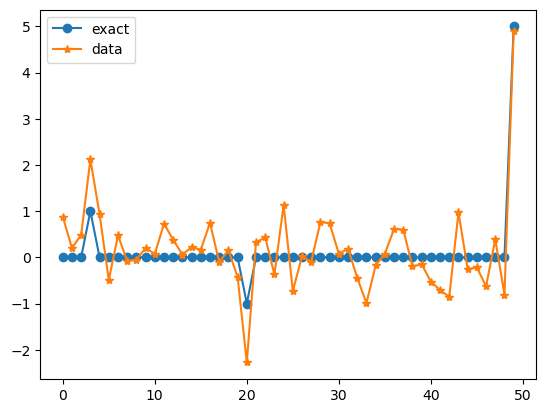

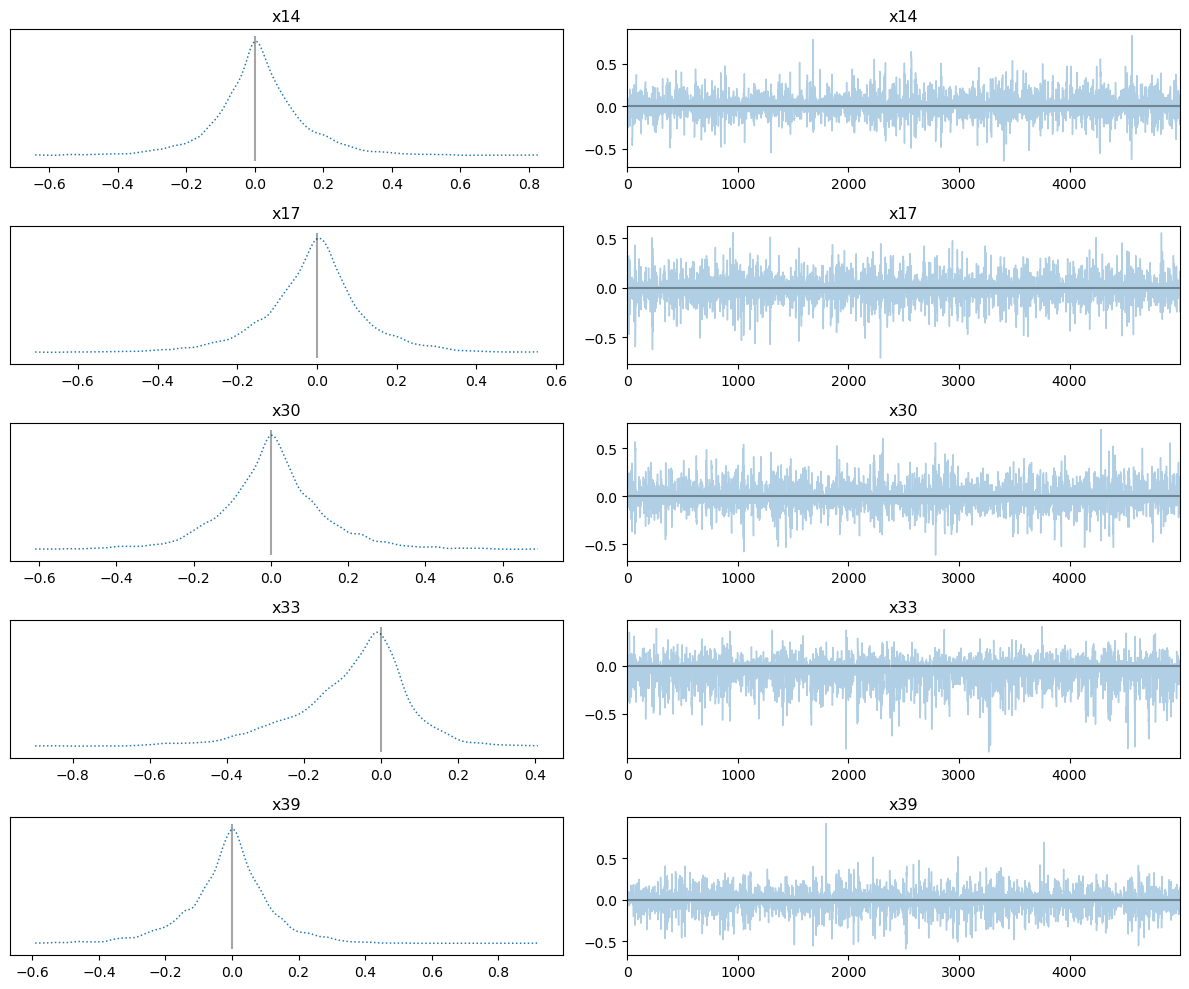

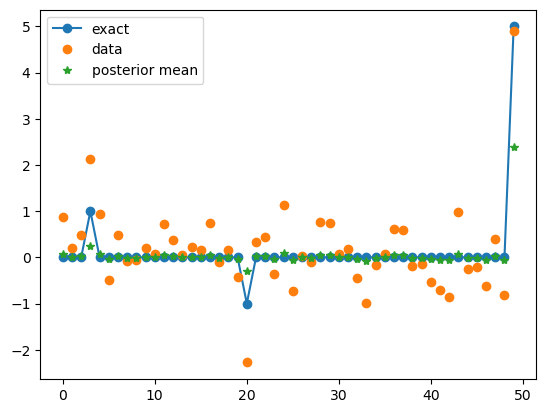

In [22]:
# # manual signal
# np.random.seed(0)
# simple_dim = 50
# x = LaplaceSmoothed(location = np.zeros(simple_dim), scale=1e-1, beta=1e-5)
# # x = cuqi.distribution.Gaussian(np.array([0, 0]), 1)

# x_exact = np.zeros(simple_dim)
# x_exact[3] = 1
# x_exact[20] = -1
# x_exact[-1] = 5
# # x_exact = x.sample().to_numpy()
# # x_exact = np.array([-1.5, 0.5])

# noise_std = 0.5
# y_data = x_exact + np.random.randn(simple_dim)*noise_std

# plt.figure()
# plt.plot(x_exact, '-o', label='exact')
# plt.plot(y_data, '-*', label='data')
# plt.legend()

# A_simple_matrix = np.eye(simple_dim)
# A_simple = cuqi.model.LinearModel(A_simple_matrix)
# y = Gaussian(A_simple@x, cov= noise_std**2)

# x_y = JointDistribution(x, y)
# p = x_y(y=y_data)
# simple_nuts = cuqi.sampler.NUTS(p)
# # simple_nuts = cuqi.sampler.MALA(p, scale=0.01)
# simple_nuts_samples = simple_nuts.sample(5000, 100)
# simple_nuts_samples.plot_trace(exact=x_exact)

# plt.figure()
# plt.plot(x_exact, '-o', label='exact')
# plt.plot(y_data, 'o', label='data')
# plt.plot(simple_nuts_samples.mean(), '*', label='posterior mean')
# plt.legend()

Sample 5100 / 5100
Selecting 5 randomly chosen variables


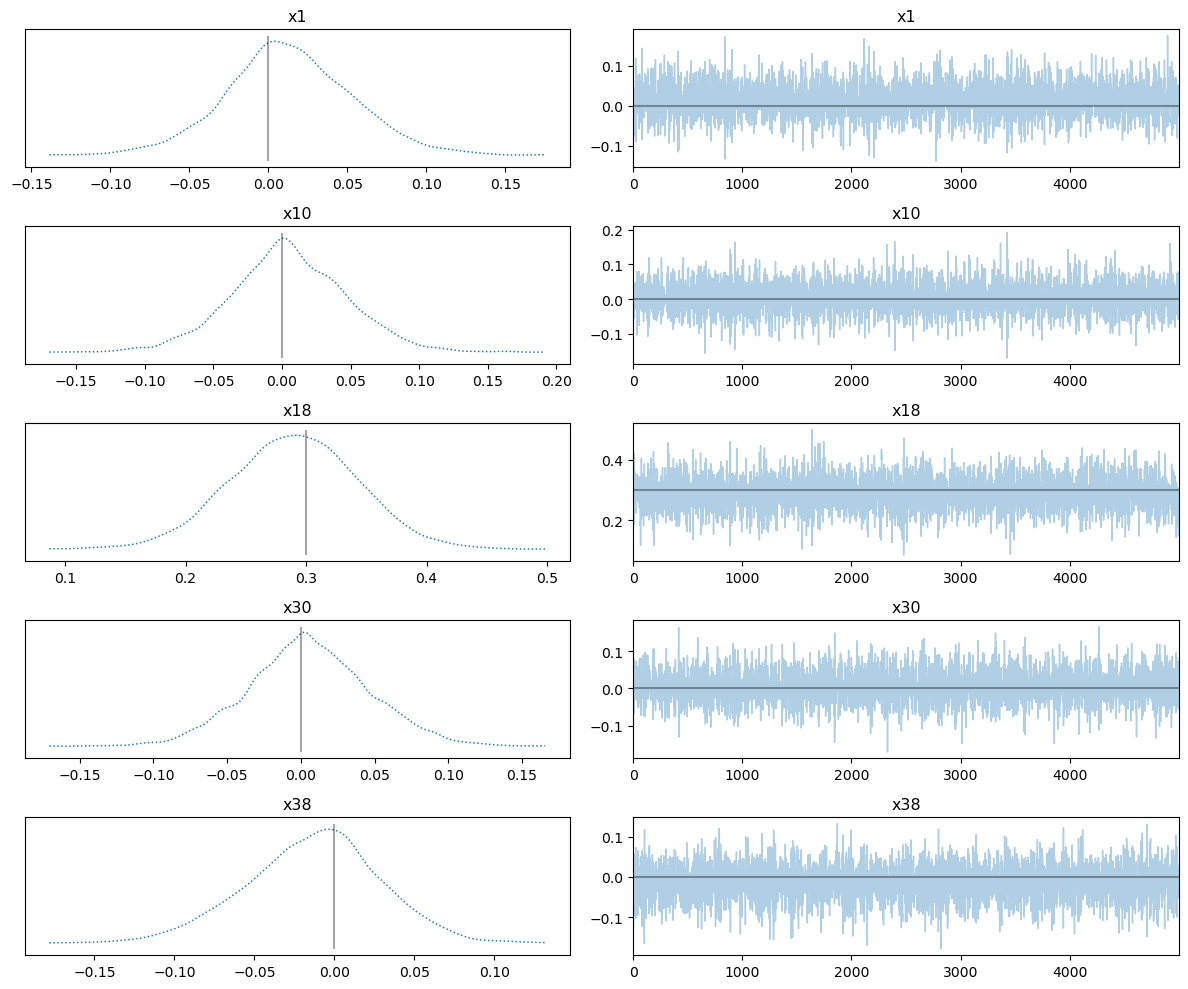

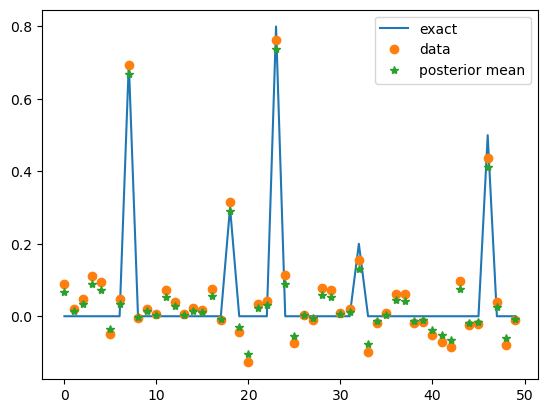

In [23]:
# # another set of manual signal
# np.random.seed(0)
# simple_dim = 50
# x = LaplaceSmoothed(location = np.zeros(simple_dim), scale=1e-1, beta=1e-5)
# # x = cuqi.distribution.Gaussian(np.array([0, 0]), 1)

# x_exact = np.zeros(simple_dim)
# x_exact[[7, 18, 23, 32, 46]] = np.array([0.7, 0.3, 0.8, 0.2, 0.5])
# # x_exact = x.sample().to_numpy()
# # x_exact = np.array([-1.5, 0.5])

# noise_std = 0.05#0.5
# y_data = x_exact + np.random.randn(simple_dim)*noise_std

# # plt.figure()
# # plt.plot(x_exact, '-o', label='exact')
# # plt.plot(y_data, '-*', label='data')
# # plt.legend()

# A_simple_matrix = np.eye(simple_dim)
# A_simple = cuqi.model.LinearModel(A_simple_matrix)
# y = Gaussian(A_simple@x, cov= noise_std**2)

# x_y = JointDistribution(x, y)
# p = x_y(y=y_data)
# simple_nuts = cuqi.sampler.NUTS(p)
# # simple_nuts = cuqi.sampler.MALA(p, scale=0.01)
# simple_nuts_samples = simple_nuts.sample(5000, 100)
# simple_nuts_samples.plot_trace(exact=x_exact)

# plt.figure()
# plt.plot(x_exact, '-', label='exact')
# plt.plot(y_data, 'o', label='data')
# plt.plot(simple_nuts_samples.mean(), '*', label='posterior mean')
# plt.legend()

### Test two ways of generating data

In [ ]:
# simple_dim = 50
# np.random.seed(2024)
# sl = 1e-1
# x = LaplaceSmoothed(location = np.zeros(simple_dim), scale=sl, beta=1e-5)

# x_exact = np.zeros(simple_dim)
# x_exact[[7, 18, 23, 32, 46]] = np.array([0.7, 0.3, 0.8, 0.2, 0.5])

# noise_std = 0.05
# # method 1
# np.random.seed(2024)
# y_data_1 = x_exact + np.random.randn(simple_dim)*noise_std
# # method 2
# np.random.seed(2024)
# A_simple_matrix = np.eye(simple_dim)
# A_simple = cuqi.model.LinearModel(A_simple_matrix)
# y = Gaussian(A_simple@x, cov= noise_std**2)
# y_data_2 = y(x=x_exact).sample()

# plt.figure()
# plt.plot(y_data_1, '-o', label='data 1')
# plt.plot(y_data_2, '-*', label='data 2')
# plt.legend()

### test with 1D identity matrix as forward operator (with different Laplace scales)

Sample 5100 / 5100
Sample 5100 / 5100
Sample 5100 / 5100
Sample 5100 / 5100
Sample 5100 / 5100


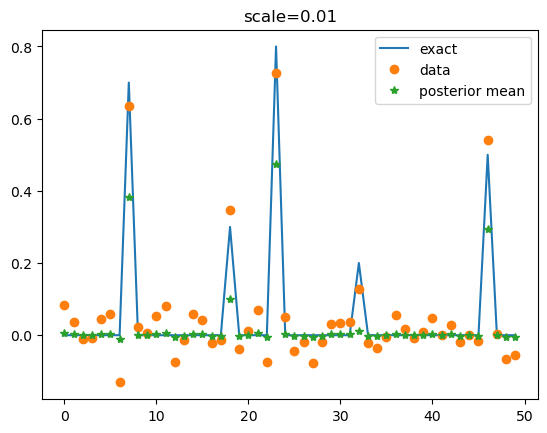

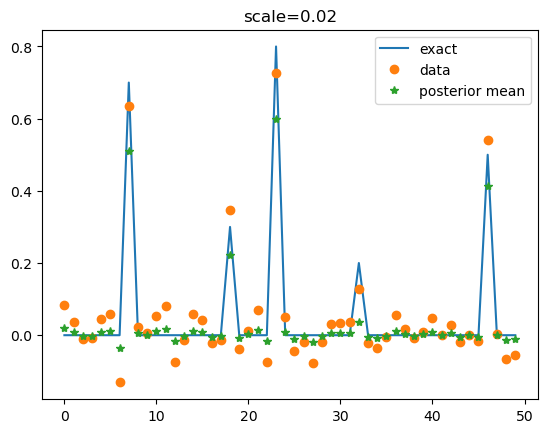

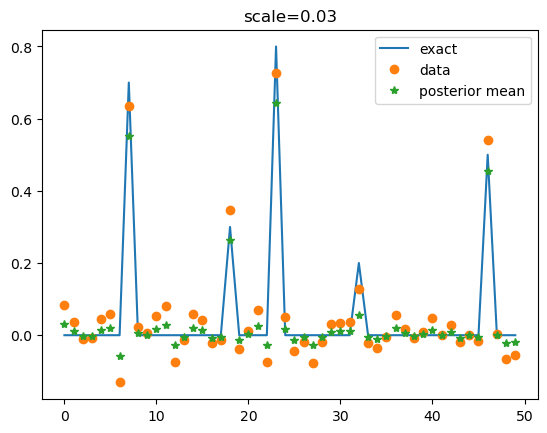

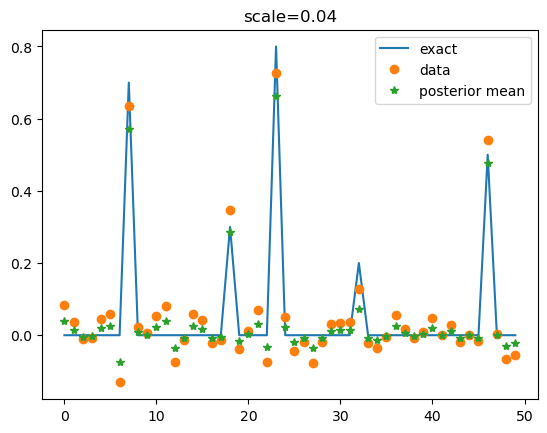

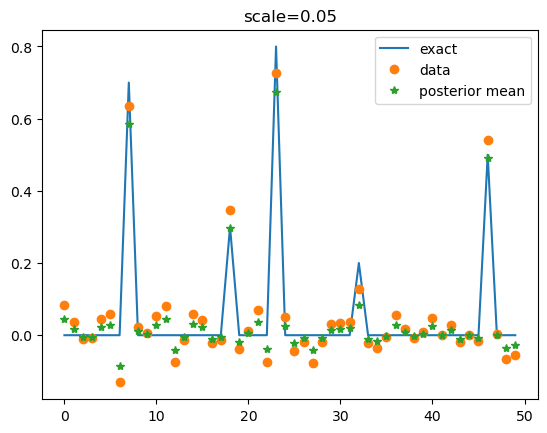

In [26]:
# another set of manual signal
# for sl in [1e-3, 1e-2, 1e-1, 1]:
for sl in [1e-2, 2e-2, 3e-2, 4e-2, 5e-2]:
    simple_dim = 50
    np.random.seed(2024)
    x = LaplaceSmoothed(location = np.zeros(simple_dim), scale=sl, beta=1e-5)
    # x = cuqi.distribution.Gaussian(np.array([0, 0]), 1)

    x_exact = np.zeros(simple_dim)
    x_exact[[7, 18, 23, 32, 46]] = np.array([0.7, 0.3, 0.8, 0.2, 0.5])
    # x_exact = x.sample().to_numpy()
    # x_exact = np.array([-1.5, 0.5])

    noise_std = 0.05#0.5
    # method 1
    # y_data = x_exact + np.random.randn(simple_dim)*noise_std

    A_simple_matrix = np.eye(simple_dim)
    A_simple = cuqi.model.LinearModel(A_simple_matrix)
    y = Gaussian(A_simple@x, cov= noise_std**2)

    # method 2
    y_data = y(x=x_exact).sample()

    x_y = JointDistribution(x, y)
    p = x_y(y=y_data)
    simple_nuts = cuqi.sampler.NUTS(p)
    # simple_nuts = cuqi.sampler.MALA(p, scale=0.01)
    simple_nuts_samples = simple_nuts.sample(5000, 100)

    # plt.figure()
    # simple_nuts_samples.plot_trace(exact=x_exact, variable_indices=[7, 18, 23, 32, 46, 10, 40])
    # plt.title(f'scale={sl}')

    plt.figure()
    plt.plot(x_exact, '-', label='exact')
    plt.plot(y_data, 'o', label='data')
    plt.plot(simple_nuts_samples.mean(), '*', label='posterior mean')
    plt.legend()
    plt.title(f'scale={sl}')

Sample 6000 / 6000
Sample 6000 / 6000
Sample 6000 / 6000
Sample 6000 / 6000


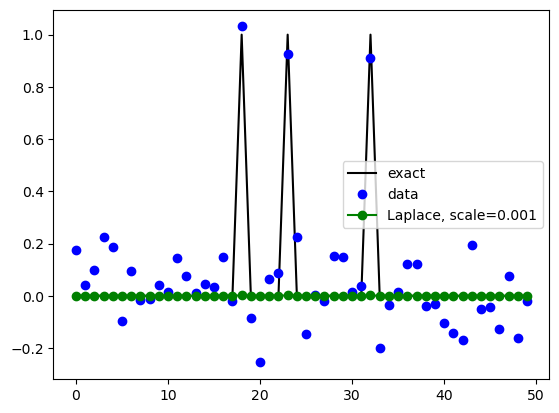

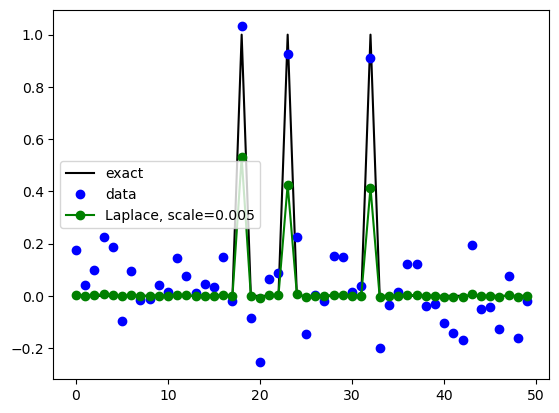

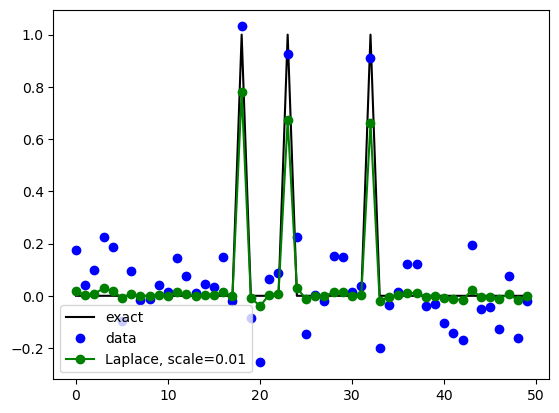

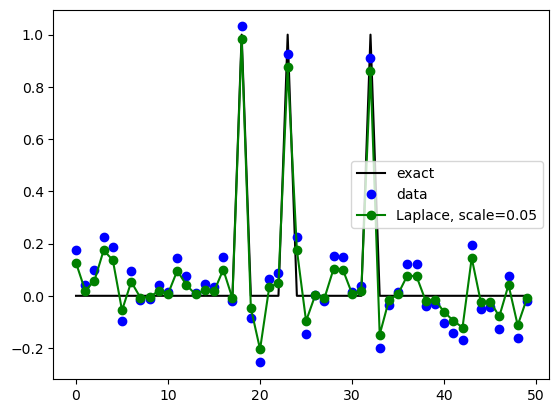

In [53]:
linestyle_str = ['-', '--', '-.', ':']
linestyle_tuple = [(0, (1, 1)), (5, (10, 3)), (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))]
# another set of manual signal
np.random.seed(0)

simple_dim = 50
x_exact = np.zeros(simple_dim)
x_exact[[18, 23, 32]] = 1
# x_exact[[7, 18, 23, 32, 46]] = np.array([0.7, 0.3, 0.8, 0.2, 0.5])
# x_exact = x.sample().to_numpy()
# x_exact = np.array([-1.5, 0.5])

noise_std = 0.1#0.05#0.5
# method 1
y_data = x_exact + np.random.randn(simple_dim)*noise_std

A_simple_matrix = np.eye(simple_dim)
A_simple = cuqi.model.LinearModel(A_simple_matrix)

# sls = [1e-3, 5e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 1e-1]
sls = [1e-3, 5e-3, 1e-2, 5e-2]

for i in range(len(sls)):
    
    np.random.seed(2024)
    x = LaplaceSmoothed(location = np.zeros(simple_dim), scale=sls[i], beta=1e-5)

    y = Gaussian(A_simple@x, cov= noise_std**2)

    x_y = JointDistribution(x, y)
    p = x_y(y=y_data)
    simple_nuts = cuqi.sampler.NUTS(p)
    simple_nuts_samples = simple_nuts.sample(5000, 1000)

    # plt.figure()
    # simple_nuts_samples.plot_trace(exact=x_exact, variable_indices=[7, 18, 23, 32, 46, 10, 40])
    # plt.title(f'scale={sl}')
    plt.figure()
    plt.plot(x_exact, 'k-', label='exact')
    plt.plot(y_data, 'bo', linewidth=0.5, label='data')

    plt.plot(simple_nuts_samples.mean(), 'g-o', linewidth=1.5, label=f'Laplace, scale={sls[i]}')
    plt.legend()
    # plt.title(f'scale={sl}')

### test with 1D deconvolution problem (with different Laplace scales)

Sample 6000 / 6000
Sample 6000 / 6000
Sample 6000 / 6000
Sample 6000 / 6000
Sample 6000 / 6000
Sample 6000 / 6000


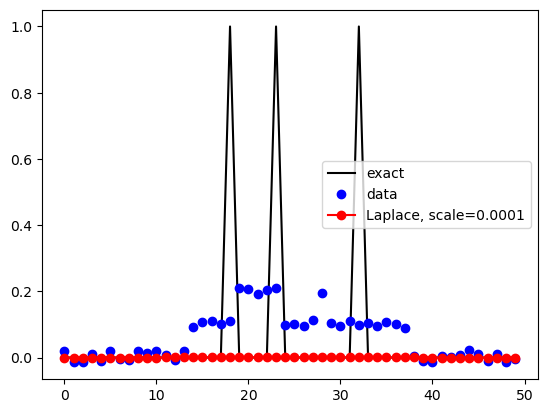

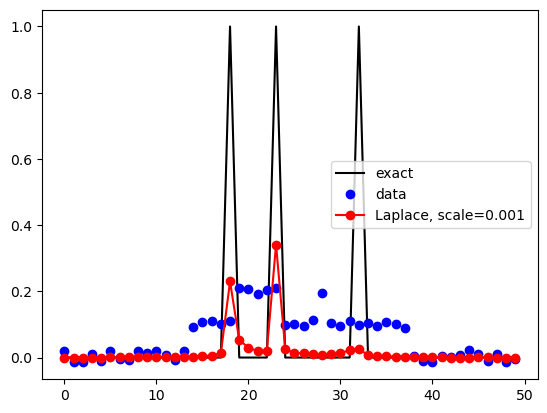

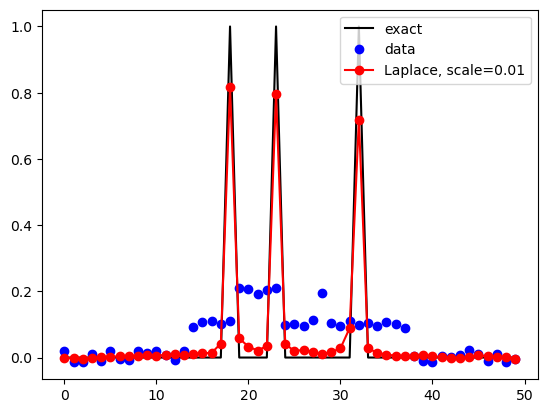

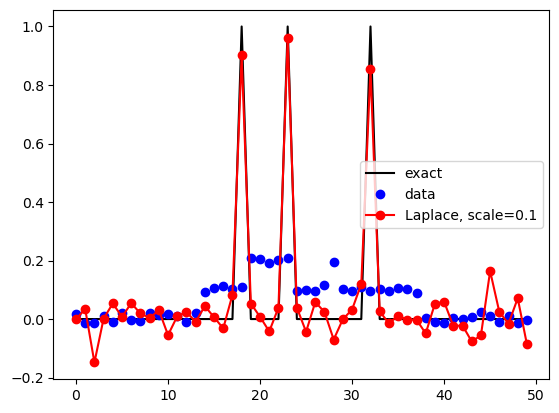

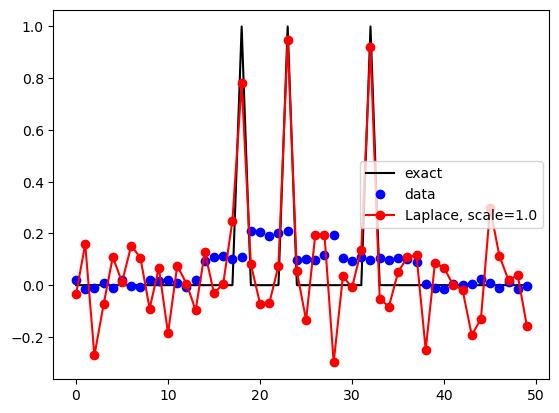

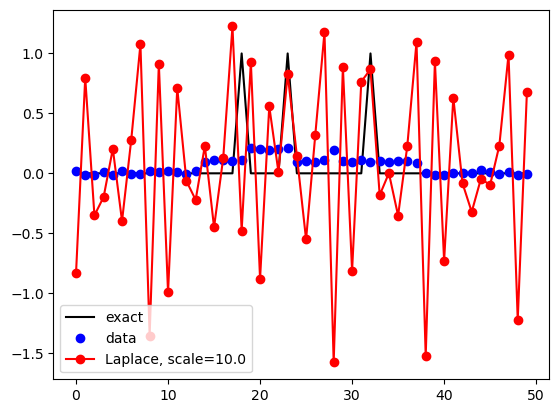

In [61]:
linestyle_str = ['-', '--', '-.', ':']
linestyle_tuple = [(0, (1, 1)), (5, (10, 3)), (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))]
# another set of manual signal
np.random.seed(0)

simple_dim = 50
x_exact = np.zeros(simple_dim)
x_exact[[18, 23, 32]] = 1
# x_exact[[7, 18, 23, 32, 46]] = np.array([0.7, 0.3, 0.8, 0.2, 0.5])
# x_exact = x.sample().to_numpy()
# x_exact = np.array([-1.5, 0.5])

noise_std = 0.01#0.05#0.5
# method 1
y_data = x_exact + np.random.randn(simple_dim)*noise_std

model, _, _ = cuqi.testproblem.Deconvolution1D(dim=simple_dim, PSF_size=10).get_components()

y_data = model@x_exact + np.random.randn(simple_dim)*noise_std

plt.figure()
plt.plot(model@x_exact, 'ko', label='exact')
plt.plot(y_data, 'bo', label='data')

# sls = [1e-3, 5e-3, 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 1e-1]
# sls = [1e-3, 5e-3, 1e-2, 5e-2]
sls = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

for i in range(len(sls)):
    
    np.random.seed(2024)
    x = LaplaceSmoothed(location = np.zeros(simple_dim), scale=sls[i], beta=1e-5)

    y = Gaussian(model@x, cov= noise_std**2)

    x_y = JointDistribution(x, y)
    p = x_y(y=y_data)
    simple_nuts = cuqi.sampler.NUTS(p)
    simple_nuts_samples = simple_nuts.sample(5000, 1000)

    # plt.figure()
    # simple_nuts_samples.plot_trace(exact=x_exact, variable_indices=[7, 18, 23, 32, 46, 10, 40])
    # plt.title(f'scale={sl}')
    plt.figure()
    plt.plot(x_exact, 'k-', label='exact')
    plt.plot(y_data, 'bo', linewidth=0.5, label='data')

    plt.plot(simple_nuts_samples.mean(), 'r-o', linewidth=1.5, label=f'Laplace, scale={sls[i]}')
    plt.legend()
    # plt.title(f'scale={sl}')

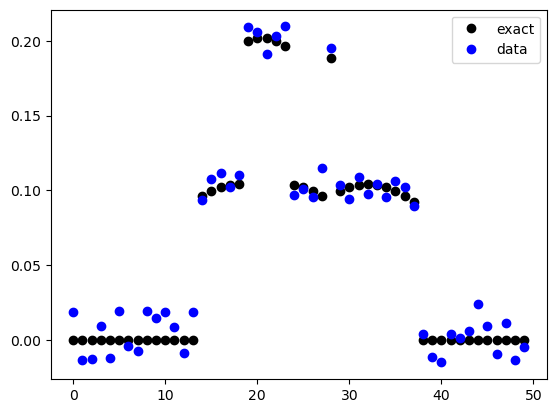

In [62]:
plt.figure()
plt.plot(model@x_exact, 'ko', label='exact')
plt.plot(y_data, 'bo', label='data')
plt.legend()

In [ ]:
# # another set of manual signal with convolution operator
# for sl in [1e-3, 1e-2, 1e-1, 1]:
#     np.random.seed(0)
#     simple_dim = 50
#     x = LaplaceSmoothed(location = np.zeros(simple_dim), scale=sl, beta=1e-5)
#     # x = cuqi.distribution.Gaussian(np.array([0, 0]), 1)

#     x_exact = np.zeros(simple_dim)
#     x_exact[[7, 18, 23, 32, 46]] = np.array([0.7, 0.3, 0.8, 0.2, 0.5])
#     # x_exact = x.sample().to_numpy()
#     # x_exact = np.array([-1.5, 0.5])

#     noise_std = 1e-2#0.05#0.5
#     # y_data = x_exact + np.random.randn(simple_dim)*noise_std

#     model, _, _ = cuqi.testproblem.Deconvolution1D(dim=simple_dim,noise_std=1,phantom='pc').get_components()

#     y_data = model@x_exact + np.random.randn(simple_dim)*noise_std

#     # A_simple_matrix = np.eye(simple_dim)
#     # A_simple = cuqi.model.LinearModel(A_simple_matrix)
#     # y = Gaussian(A_simple@x, cov= noise_std**2)
#     y = Gaussian(model@x, cov= noise_std**2)

#     x_y = JointDistribution(x, y)
#     p = x_y(y=y_data)
#     simple_nuts = cuqi.sampler.NUTS(p)
#     # simple_nuts = cuqi.sampler.MALA(p, scale=0.01)
#     simple_nuts_samples = simple_nuts.sample(5000, 100)
#     # simple_nuts_samples.plot_trace(exact=x_exact)

#     plt.figure()
#     plt.plot(x_exact, '-', label='exact')
#     plt.plot(y_data, 'o', label='data')
#     plt.plot(simple_nuts_samples.mean(), '*', label='posterior mean')
#     plt.legend()
#     plt.title(f'scale={sl}')

In [ ]:
# # another set of manual signal with convolution operator
# for sl in [1e-3, 1e-2, 1e-1, 1]:
#     np.random.seed(0)
#     simple_dim = 50
#     x = LaplaceSmoothed(location = np.zeros(simple_dim), scale=sl, beta=1e-5)
#     # x = cuqi.distribution.Gaussian(np.array([0, 0]), 1)

#     x_exact = np.zeros(simple_dim)
#     x_exact[10:20] = 1
#     # x_exact[[7, 18, 23, 32, 46]] = np.array([0.7, 0.3, 0.8, 0.2, 0.5])
#     # x_exact = x.sample().to_numpy()
#     # x_exact = np.array([-1.5, 0.5])

#     noise_std = 1e-2#0.05#0.5
#     # y_data = x_exact + np.random.randn(simple_dim)*noise_std

#     model, _, _ = cuqi.testproblem.Deconvolution1D(dim=simple_dim,noise_std=1,phantom='pc').get_components()

#     y_data = model@x_exact + np.random.randn(simple_dim)*noise_std

#     # A_simple_matrix = np.eye(simple_dim)
#     # A_simple = cuqi.model.LinearModel(A_simple_matrix)
#     # y = Gaussian(A_simple@x, cov= noise_std**2)
#     y = Gaussian(model@x, cov= noise_std**2)

#     x_y = JointDistribution(x, y)
#     p = x_y(y=y_data)
#     simple_nuts = cuqi.sampler.NUTS(p)
#     # simple_nuts = cuqi.sampler.MALA(p, scale=0.01)
#     simple_nuts_samples = simple_nuts.sample(5000, 100)
#     # simple_nuts_samples.plot_trace(exact=x_exact)

#     plt.figure()
#     plt.plot(x_exact, '-', label='exact')
#     plt.plot(y_data, 'o', label='data')
#     plt.plot(simple_nuts_samples.mean(), '*', label='posterior mean')
#     plt.legend()
#     plt.title(f'scale={sl}')